# MVP Retrieval

The goal of this MVP version is to come up with a recommendation engine that will be able to suggest each user a list of potential Video Games that they would have rated highly if they had played.

The list of recommendations should be displayed to each user when they visit our site or sent to them via email marketing.

The proxy metrics we choose for this goal is: `NDCG@10`.

This notebook explores the first component of the system: Retrieval

# Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import mlflow
from datetime import datetime
from datetime import timedelta
from dotenv import load_dotenv
from loguru import logger
from typing import List
from tqdm.notebook import tqdm

from pydantic import BaseModel
import datasets
from datasets import load_dataset

import pandas as pd

datasets.logging.set_verbosity_error()

load_dotenv()
sys.path.insert(0, '..')

# Set up plot styling
from src.utils.time import log_time
from src.visualization.setup import color_scheme, fsds_colors

# Controller

In [3]:
class Args(BaseModel):
    testing: bool = False
    log_to_mlflow: bool = True
    experiment_name: str = "FSDS RecSys - L3 - MVP"
    run_name: str = '001-popular-vs-random'
    hf_dataset_path: str = "McAuley-Lab/Amazon-Reviews-2023"
    notebook_persist_dir: str = None
    random_seed: int = 41

    train_num_days: int = 90
    val_num_days: int = 7
    test_num_days: int = 7
    fit_num_days: int = None

    def init(self):
        self.notebook_persist_dir = os.path.abspath(f"data/{self.run_name}")

        if self.testing:
            logger.info("testing=True so downsampling the data...")
            self.train_num_days = 7
            self.val_num_days = 1
            self.test_num_days = 1

        self.fit_num_days = self.train_num_days + self.val_num_days + self.test_num_days
        
        if not os.environ.get("MLFLOW_TRACKING_URI"):
            logger.warning(
                f"Environment variable MLFLOW_TRACKING_URI is not set. Setting self.log_to_mlflow to false."
            )
            self.log_to_mlflow = False

        if self.log_to_mlflow:
            logger.info(
                f"Setting up MLflow experiment {self.experiment_name} - run {self.run_name}..."
            )
            import mlflow

            mlflow.set_experiment(self.experiment_name)
            mlflow.start_run(run_name=self.run_name)

        return self
    
args = Args().init()

print(args.model_dump_json(indent=2))

2024-09-01 09:03:16.715 | INFO     | __main__:init:33 - Setting up MLflow experiment FSDS RecSys - L3 - MVP - run 001-popular-vs-random...


{
  "testing": false,
  "log_to_mlflow": true,
  "experiment_name": "FSDS RecSys - L3 - MVP",
  "run_name": "001-popular-vs-random",
  "hf_dataset_path": "McAuley-Lab/Amazon-Reviews-2023",
  "notebook_persist_dir": "/home/dvquys/frostmourne/fsds/recsys/notebooks/data/001-popular-vs-random",
  "random_seed": 41,
  "train_num_days": 90,
  "val_num_days": 7,
  "test_num_days": 7,
  "fit_num_days": 104
}


# Load data

In [4]:
metadata = load_dataset(args.hf_dataset_path, name="raw_meta_Video_Games", split="full", trust_remote_code=True)

In [5]:
metadata[0]

{'main_category': 'Video Games',
 'title': 'Dash 8-300 Professional Add-On',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Features Dash 8-300 and 8-Q300 ('Q' rollout livery)",
  'Airlines - US Airways, South African Express, Bahamasair, Augsburg Airways, Lufthansa Cityline, British Airways (Union Jack), British European, FlyBe, Intersky, Wideroe, Iberia, Tyrolean, QantasLink, BWIA',
  'Airports include - London City, Frankfurt, Milan and Amsterdam Schipol',
  'Includes PSS PanelConfig and LoadEdit tools'],
 'description': ['The Dash 8-300 Professional Add-On lets you pilot a real commuter special. Fly two versions of the popular Dash 8-300 in a total of 17 different liveries. The Dash 8-300 is one of the most popular short-haul aircraft available and this superbly modelled version from acclaimed aircraft developers PSS is modelled in two versions with a total of 17 different liveries. The package also includes scenery for three European airports, tutorials, tutorial flig

In [6]:
dataset = load_dataset(args.hf_dataset_path, name="0core_rating_only_Video_Games", trust_remote_code=True)
# To load all user review data such as review_text, helpful score, use: name="raw_review_All_Beauty"

In [7]:
dataset

DatasetDict({
    full: Dataset({
        features: ['user_id', 'parent_asin', 'rating', 'timestamp'],
        num_rows: 4555500
    })
})

In [8]:
dataset['full'][0]

{'user_id': 'AGCI7FAH4GL5FI65HYLKWTMFZ2CQ',
 'parent_asin': 'B07SRWRH5D',
 'rating': '5.0',
 'timestamp': '1587051114941'}

In [9]:
metadata[0]

{'main_category': 'Video Games',
 'title': 'Dash 8-300 Professional Add-On',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Features Dash 8-300 and 8-Q300 ('Q' rollout livery)",
  'Airlines - US Airways, South African Express, Bahamasair, Augsburg Airways, Lufthansa Cityline, British Airways (Union Jack), British European, FlyBe, Intersky, Wideroe, Iberia, Tyrolean, QantasLink, BWIA',
  'Airports include - London City, Frankfurt, Milan and Amsterdam Schipol',
  'Includes PSS PanelConfig and LoadEdit tools'],
 'description': ['The Dash 8-300 Professional Add-On lets you pilot a real commuter special. Fly two versions of the popular Dash 8-300 in a total of 17 different liveries. The Dash 8-300 is one of the most popular short-haul aircraft available and this superbly modelled version from acclaimed aircraft developers PSS is modelled in two versions with a total of 17 different liveries. The package also includes scenery for three European airports, tutorials, tutorial flig

# Split train-val-test
We would split the dataset by absolute timestamp, leaving 7 days of data in our validation and 7 days of data in our test set. This splitting strategy mimics the production environment where our models are trained to predict on future data. Even though in practice we may retrain model everyday, we hold out 7 days of data to account for the fact that choosing one day data as validation have a high risk of not representing the true populations since there might be special events on that day.

In [10]:
raw_df = dataset['full'].to_pandas()

In [11]:
raw_df

,user_id,parent_asin,rating,timestamp
0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07SRWRH5D,5.0,1587051114941
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07DK1H3H5,4.0,1608186804795
2,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,B07MFMFW34,5.0,1490877431000
3,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,B00HUWA45W,5.0,1427591932000
4,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,B0BCHWZX95,5.0,1577637634017
...,...,...,...,...
4555495,AEGJO3XG3JGBVIJW64SDJ6BIYWHQ,B0C89J78ZW,5.0,1694315538121
4555496,AHTYCU6NSHJ4BY7R2YNDIDGUXS6Q,B089F1BD4W,5.0,1600863891023
4555497,AF4KDWDGCJSUEB7JESQZ6ZWD2LNA,B0BN942894,5.0,1584887999168
4555498,AG3BHCQJCY3MPNP3UKVAENSGQM2A,B09SM83KRP,1.0,1666690302530


In [12]:
metadata_raw_df = metadata.to_pandas()

In [13]:
metadata_raw_df

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Video Games,Dash 8-300 Professional Add-On,5.0,1,[Features Dash 8-300 and 8-Q300 ('Q' rollout l...,[The Dash 8-300 Professional Add-On lets you p...,None,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Aerosoft,"[Video Games, PC, Games]","{""Pricing"": ""The strikethrough price is the Li...",B000FH0MHO,None,None,None
1,Video Games,Phantasmagoria: A Puzzle of Flesh,4.1,18,[Windows 95],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Sierra,"[Video Games, PC, Games]","{""Best Sellers Rank"": {""Video Games"": 137612, ...",B00069EVOG,None,None,None
2,Video Games,NBA 2K17 - Early Tip Off Edition - PlayStation 4,4.3,223,[The #1 rated NBA video game simulation series...,[Following the record-breaking launch of NBA 2...,58.0,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['NBA 2K17 - Kobe: Haters vs Players...,2K,"[Video Games, PlayStation 4, Games]","{""Release date"": ""September 16, 2016"", ""Best S...",B00Z9TLVK0,None,None,None
3,Video Games,Nintendo Selects: The Legend of Zelda Ocarina ...,4.9,22,[Authentic Nintendo Selects: The Legend of Zel...,[],37.42,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Amazon Renewed,"[Video Games, Legacy Systems, Nintendo Systems...","{""Best Sellers Rank"": {""Video Games"": 51019, ""...",B07SZJZV88,None,None,None
4,Video Games,Thrustmaster Elite Fitness Pack for Nintendo Wii,3.0,3,"[Includes (9) Total Accessories, Pedometer, Wi...",[The Thrustmaster Motion Plus Elite Fitness Pa...,None,"{'hi_res': [None, None, None, None, None, None...","{'title': [], 'url': [], 'user_id': []}",THRUSTMASTER,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""November 1, 2009"", ""Pricing""...",B002WH4ZJG,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137264,None,Story of Seasons: Pioneers Of Olive Town (Nint...,4.5,397,[A wild world of discovery - tame the wilderne...,"[Product Description, Inspired by Tales of you...",31.04,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Marvelous Europe,"[Video Games, Nintendo Switch, Games]","{""Release date"": ""March 26, 2021"", ""Best Selle...",B09XQJS4CZ,None,None,None
137265,Video Games,MotoGP 18 (PC DVD) UK IMPORT REGION FREE,4.0,1,[Brand new game engine - MotoGP18 has been reb...,[Become the champion of the 2018 MotoGP Season...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Milestone,"[Video Games, Game Genre of the Month]","{""Pricing"": ""The strikethrough price is the Li...",B07DGPTGNV,None,None,None
137266,Cell Phones & Accessories,Century Accessory Soft Silicone Protective Ski...,2.9,19,"[Easy access to all buttons, controls and port...",[This soft case cover will add a splash of col...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Century Accessory,"[Video Games, Legacy Systems, Xbox Systems, Xb...","{""Package Dimensions"": ""2.76 x 2.76 x 0.2 inch...",B00HUWCQBW,None,None,None
137267,None,Hasbro Interactive Mr. Potato Head Activity Pa...,3.9,5,[],"[Amazon.com, Everyone's favorite master-of-dis...",None,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Hasbro,"[Video Games, PC, Games]","{""Release date"": ""July 24, 1999"", ""Best Seller...",B00002S9MH,None,None,None


## Select the period for modeling

In [14]:
import plotly.express as px

from src.utils.data_prep import parse_dt, handle_dtypes

In [15]:
raw_df = (
    raw_df
    .pipe(parse_dt)
    .pipe(handle_dtypes)
)

However, we would like to inspect the data to make sure we choose a representative subset of data. The most recent data might have less data due to cutoff and other things we don't know.

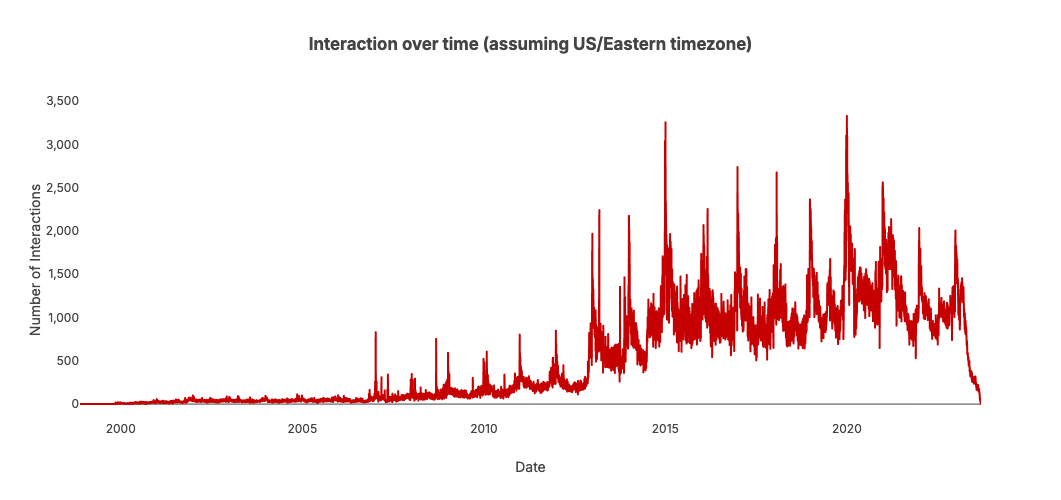

In [19]:
def plot_interaction_over_time(df, timezone='US/Eastern'):
    plot_df = df.assign(
        timestamp_date=df['timestamp'].dt.tz_localize('UTC').dt.tz_convert(timezone).dt.date
    )
    
    plot_agg_df = plot_df.groupby('timestamp_date').size()
    
    # Create the plot
    fig = px.line(
        x=plot_agg_df.index,
        y=plot_agg_df.values,
        labels={'x': 'Date', 'y': 'Number of Interactions'},
        title=f'Interaction over time (assuming {timezone} timezone)',
        height=500,
        width=1100
    )

    fig.update_layout(yaxis=dict(showticklabels=True, tickformat=","))

    fig.show()

timezone = 'US/Eastern'  # Assume this time zone because the data is Amazon Data
plot_interaction_over_time(raw_df, timezone)

Looks like we do have a data collection problem at the end of the dataset span. The line is steeper and reaching zero.

On the other hand, the peak around Dec 2022 is a good candidate that balances recency and completeness. We choose to model data around this peak period because our models should be designed to work well in this time of the year to maximize values.

In [17]:
max_date = datetime.strptime("2023-01-07", "%Y-%m-%d")
fit_min_date = max_date - timedelta(days=args.fit_num_days)

In [18]:
fit_df = raw_df.loc[lambda df: df['timestamp'].between(fit_min_date, max_date)]

In [19]:
fit_df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,121672,95541,AF3T3YI4DGABBU3CNRW2UASWCOMA,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parent_asin,121672,20949,B07V8YSBFG,1166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,121672.0,NaN,NaN,NaN,3.932803,1.0,3.0,5.0,5.0,5.0,1.512106
timestamp,121672,NaN,NaN,NaN,2022-11-20 12:38:56.630720768,2022-09-25 00:00:33.663000,2022-10-25 02:26:30.932000,2022-11-22 01:36:38.600999936,2022-12-18 01:48:24.887749888,2023-01-06 23:59:42.997000,NaN


## Split

In [20]:
from src.features.split import train_test_split_timebased

In [21]:
train_df, val_df, test_df = train_test_split_timebased(fit_df, args)

2024-08-30 21:10:22.757 | INFO     | src.features.split.timebased:train_test_split_timebased:28 - Removing the new users in val and test sets...
2024-08-30 21:10:22.802 | INFO     | src.features.split.timebased:train_test_split_timebased:34 - Removed 8950 users from val set
2024-08-30 21:10:22.803 | INFO     | src.features.split.timebased:train_test_split_timebased:37 - Removed 10969 users from test set


In [22]:
plot_interaction_over_time(train_df, timezone)

In [23]:
plot_interaction_over_time(val_df, timezone)

In [24]:
plot_interaction_over_time(test_df, timezone)

# Popular Retriever

In [25]:
class CommonModelParams(BaseModel):
    top_K: int = 100
    top_k: int = 10
    num_epochs: int = 100

    compare_random: bool = True 

cmparams = CommonModelParams()

In [26]:
popular_items_df = (
    train_df
    .groupby('parent_asin', as_index=False)
    .size()
    .assign(
        rec_ranking=lambda df: df['size'].rank(method='first', ascending=False)
    )
    .sort_values(['rec_ranking'], ascending=[True])
    .head(cmparams.top_K)
)

popular_items_df

,parent_asin,size,rec_ranking
5613,B07V8YSBFG,770,1.0
13365,B09TQBJCJ6,646,2.0
17954,B0BZFWMYSQ,536,3.0
8251,B08LT6PT1X,457,4.0
13914,B09XM8MMYD,357,5.0
...,...,...,...
13457,B09V25XG1G,81,96.0
17466,B0BN3SDBC5,81,97.0
5882,B07X1TFSQ4,80,98.0
6926,B087NNZZM8,80,99.0


In [27]:
popular_recs = (
    val_df[['user_id']].drop_duplicates().assign(tmp=1)
    .pipe(lambda df: pd.merge(
        df,
        popular_items_df.assign(tmp=1),
        on='tmp',
        how='left'
    ))
    [['user_id', 'parent_asin', 'rec_ranking']]
)
    
popular_recs

,user_id,parent_asin,rec_ranking
0,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B07V8YSBFG,1.0
1,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09TQBJCJ6,2.0
2,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0BZFWMYSQ,3.0
3,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B08LT6PT1X,4.0
4,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09XM8MMYD,5.0
...,...,...,...
89895,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B09V25XG1G,96.0
89896,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B0BN3SDBC5,97.0
89897,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B07X1TFSQ4,98.0
89898,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B087NNZZM8,99.0


# Random Retriever

In [28]:
from src.utils.hash import hash_string_to_int
import numpy as np

def random_rec(user_id: int, all_items: List[str]) -> List[str]:
    random_seed = hash_string_to_int(str(user_id))
    random_seed = str(random_seed)[-8:]  # To prevent reaching upper bound of np.random.seed
    random_seed = int(random_seed)
    np.random.seed(random_seed)
    recs = np.random.choice(all_items, cmparams.top_K, replace=False)
    return recs

all_items = train_df['parent_asin'].unique()


if cmparams.compare_random:
    random_recs_list = []
    for user_id in tqdm(val_df['user_id'].unique(), total=val_df['user_id'].nunique()):
        uid_random_recs = random_rec(user_id, all_items)
        uid_random_recs_df = (
            pd.DataFrame(uid_random_recs, columns=['parent_asin'])
            .reset_index()
            .assign(
                user_id=user_id,
                index=lambda df: df['index'] + 1
            )
            .rename(columns={'index': 'rec_ranking'})
            [['user_id', 'parent_asin', 'rec_ranking']]
        )
        random_recs_list.append(uid_random_recs_df)
    random_recs_df = pd.concat(random_recs_list, axis=0)

  0%|          | 0/899 [00:00<?, ?it/s]

In [29]:
random_recs_df

,user_id,parent_asin,rec_ranking
0,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0BZC1WM2F,1
1,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B082DYPMGF,2
2,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09X8YWG5S,3
3,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B088KF3Z9R,4
4,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09436JVZR,5
...,...,...,...
95,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B07WZ78VRN,96
96,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B0B9QPRYSL,97
97,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B08NHFZJFQ,98
98,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B09GVL3ZP3,99


# Evaluate

In [30]:
def merge_recs_with_target(recs_df, label_df):
    return (
        recs_df
        .pipe(
            lambda df: pd.merge(
                df,
                label_df[['user_id', 'parent_asin', 'rating_rank']],
                on=['user_id', 'parent_asin'],
                how='outer'
            )
        )
        .assign(
            rating_rank=lambda df: df['rating_rank'].fillna(0).astype(int),
            # Fill the recall with ranking = top_K + 1 so that the recall calculation is correct
            rec_ranking=lambda df: df['rec_ranking'].fillna(cmparams.top_K + 1).astype(int)
        )
        .sort_values(['user_id', 'rec_ranking'])
    )

In [31]:
label_cols = ['user_id', 'parent_asin', 'rating_rank']
label_df = (
    val_df
    .sort_values(['timestamp'], ascending=[False])
    .assign(
        rating_rank=lambda df: df.groupby('user_id')['rating'].rank(method='first', ascending=False)
    )
    .sort_values(['rating_rank'], ascending=[True])
    [label_cols]
)
label_df

,user_id,parent_asin,rating_rank
606973,AGOS2NWQ7DZ7DZ5VWCHHF7E2RHWA,B0BQMYZHV2,1.0
593170,AEEOK67NRJ4J25WJYWXB3GDJLQPA,B0BCG3ZWR4,1.0
3093261,AEDT25C43KKJ4VK2KGUG5IYKZZHQ,B097QLXM6G,1.0
1519140,AGZO4U4BTKD7NFV2GFFGGKXTXDCA,B09FJ5TZQZ,1.0
850720,AE6GY2WHNGFBJ2K2NB5BX4L7CD2Q,B08NDYQSXZ,1.0
...,...,...,...
834321,AHQMFHKCC7RDUBAZELFJLFVI456Q,B002I0K74Y,11.0
3596503,AEIONHAIBTFVS5EM3PGBPAZUNCLA,B08MBKBH72,12.0
834320,AHQMFHKCC7RDUBAZELFJLFVI456Q,B094YHB1QK,12.0
3596502,AEIONHAIBTFVS5EM3PGBPAZUNCLA,B09N568WBD,13.0


In [32]:
popular_recs_target = merge_recs_with_target(popular_recs, label_df)
popular_recs_target

,user_id,parent_asin,rec_ranking,rating_rank
6,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B07V8YSBFG,1,0
37,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B09TQBJCJ6,2,0
80,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0BZFWMYSQ,3,0
20,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B08LT6PT1X,4,0
44,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B09XM8MMYD,5,0
...,...,...,...,...
90912,AHZSTXPC6QU72F2ND5UV53RDYICA,B0BN3SDBC5,97,0
90853,AHZSTXPC6QU72F2ND5UV53RDYICA,B07X1TFSQ4,98,0
90857,AHZSTXPC6QU72F2ND5UV53RDYICA,B087NNZZM8,99,0
90869,AHZSTXPC6QU72F2ND5UV53RDYICA,B09B35J159,100,0


In [33]:
random_recs_target = merge_recs_with_target(random_recs_df, label_df)
random_recs_target

,user_id,parent_asin,rec_ranking,rating_rank
41,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B08R8MXDLY,1,0
19,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B07HW3KF87,2,0
54,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B09GF5RHD9,3,0
88,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0B8WZ2VSD,4,0
94,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0BKGC4H6X,5,0
...,...,...,...,...
90974,AHZSTXPC6QU72F2ND5UV53RDYICA,B07GRSVQ48,97,0
90987,AHZSTXPC6QU72F2ND5UV53RDYICA,B07VQ1ZHY1,98,0
91024,AHZSTXPC6QU72F2ND5UV53RDYICA,B09PFPRZR1,99,0
91035,AHZSTXPC6QU72F2ND5UV53RDYICA,B09YHWZ53T,100,0


## Evaluate with Evidently

In [34]:
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import RecsysPreset
from evidently.metrics import PrecisionTopKMetric
from evidently.metrics import RecallTopKMetric
from evidently.metrics import FBetaTopKMetric
from evidently.metrics import MAPKMetric
from evidently.metrics import NDCGKMetric
from evidently.metrics import NoveltyMetric
from evidently.metrics import PersonalizationMetric
from evidently.metrics import HitRateKMetric
from evidently.metrics import MRRKMetric
from evidently.metrics import RecCasesTable

from src.features.eval.evidently.popularity_bias import PopularityBias

In [35]:
column_mapping = ColumnMapping(
    recommendations_type='rank',
    target='rating_rank',
    prediction='rec_ranking',
    item_id='parent_asin',
    user_id='user_id'
)

fighters = {
    'current': {
        'name': 'popular',
        'recs': popular_recs_target
    },
    'reference': {
        'name': 'random',
        'recs': random_recs_target
    }
}

report = Report(metrics=[
    NDCGKMetric(k=cmparams.top_k),
    RecallTopKMetric(k=cmparams.top_K),
    PrecisionTopKMetric(k=cmparams.top_k),
    FBetaTopKMetric(k=cmparams.top_k),
    MAPKMetric(k=cmparams.top_k),
    MRRKMetric(k=cmparams.top_k),
    NoveltyMetric(k=cmparams.top_k),
    PersonalizationMetric(k=cmparams.top_k),
    PopularityBias(k=cmparams.top_k),
    RecCasesTable(item_num=cmparams.top_k)
], options=[color_scheme])

log_time(printer=logger.info, method_name='generate_evidently_report')(report.run)(
    reference_data=fighters['reference']['recs'],
    current_data=fighters['current']['recs'],
    column_mapping=column_mapping,
    additional_data={'current_train_data': train_df}
)

evidently_report_fp = f"{args.notebook_persist_dir}/{fighters['current']['name']}_vs_{fighters['reference']['name']}_evidently_report.html"
os.makedirs(args.notebook_persist_dir, exist_ok=True)
report.save_html(evidently_report_fp)

if args.log_to_mlflow:
    mlflow.log_artifact(evidently_report_fp)

/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:55: FutureWarning:

Support for axis=1 in DataFrame.expanding is deprecated and will be removed in a future version. Use obj.T.expanding(...) instead

/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:64: FutureWarning:

Support for axis=1 in DataFrame.expanding is deprecated and will be removed in a future version. Use obj.T.expanding(...) instead

/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:75: FutureWarning:

Support for axis=1 in DataFrame.expanding is deprecated and will be removed in a future version. Use obj.T.expanding(...) instead

/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:84: FutureWarning:

Support for axis=1 in DataFrame.expanding is deprec

# Clean up

In [36]:
mlflow.end_run()

2024/08/30 21:10:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run 001-popular-vs-random at: http://localhost:5002/#/experiments/3/runs/5421875740b448659552aad54d2fdb49.
2024/08/30 21:10:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5002/#/experiments/3.
